# Define Resnet model for CIFAR-10

In [1]:
# Referenced: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F


def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight)
        

class IdentityMapping(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(IdentityMapping, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
    def forward(self, x):
        out = x
        # option A from https://arxiv.org/pdf/1512.03385.pdf
        if self.in_channels != self.out_channels:
            num_of_pad = self.out_channels - self.in_channels
            out = F.pad(out[:, :, ::2, ::2], (0, 0, 0, 0, num_of_pad//2, num_of_pad//2))
            
        return out


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = IdentityMapping(in_channels, out_channels)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(x)
        out = self.relu(out)
        
        return out

    
class Resnet(nn.Module):
    def __init__(self, layers, num_classes=10):
        super(Resnet, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layers1 = self._make_layer(layers[0], 16, 16, stride=1)
        self.layers2 = self._make_layer(layers[1], 16, 32, stride=2)
        self.layers3 = self._make_layer(layers[2], 32, 64, stride=2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
        # weight initialization
        self.apply(init_weights)
        
    def _make_layer(self, num_of_blocks, in_channels, out_channels, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for i in range(num_of_blocks - 1):
            layers.append(ResidualBlock(out_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layers1(out)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        
        return out

# Load the CIFAR-10

In [2]:
import torchvision
import torchvision.transforms as transforms

# calculate mean/std of dataset
dataset = torchvision.datasets.CIFAR10('../../data', train=True, download=True, transform=transforms.ToTensor())
mean = dataset.data.mean(axis=(0, 1, 2)) / 255
std = dataset.data.std(axis=(0, 1, 2)) / 255

train_transforms = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10('../../data', train=True, download=True, transform=train_transforms)
validset = torchvision.datasets.CIFAR10('../../data', train=False, download=True, transform=valid_transforms)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=128, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Train Resnet

In [3]:
import os
import torch.optim as optim


def train(train_loader, model, criterion, optimizer):
    model.train()
    
    losses = []
    errors = []
    
    epoch_results = {
        'mean_loss': 0.,
        'mean_error': 0.
    }
    
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.cuda()
        labels = labels.cuda()
        
        output = model(imgs)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        errors.append(1. - torch.mean((torch.argmax(output, dim=1) == labels).float()).item())
        
    epoch_results['mean_loss'] = np.mean(losses)
    epoch_results['mean_error'] = np.mean(errors)
    
    print(f'Train loss: {epoch_results["mean_loss"]}')
    print(f'Train error rate: {epoch_results["mean_error"]}')
    
    return epoch_results
        
def validate(valid_loader, model, criterion):
    model.eval()
    
    losses = []
    errors = []
    
    epoch_results = {
        'mean_loss': 0.,
        'mean_error': 0.
    }
    
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(valid_loader):
            imgs = imgs.cuda()
            labels = labels.cuda()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            losses.append(loss.item())
            errors.append(1. - torch.mean((torch.argmax(output, dim=1) == labels).float()).item())
            
    epoch_results['mean_loss'] = np.mean(losses)
    epoch_results['mean_error'] = np.mean(errors)
    
    print(f'Valid loss: {epoch_results["mean_loss"]}')
    print(f'Valid error rate: {epoch_results["mean_error"]}')
            
    return epoch_results

In [4]:
import numpy as np

os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3'

lr = 0.1
momentum = 0.9
weight_decay = 1e-4
epochs = 164  # 64k steps = 164 epochs
lr_milestones = [82, 123] # 32k steps = 82 epochs & 48k = 123 epochs

resnet = Resnet([9, 9, 9], num_classes=10)
resnet = nn.DataParallel(resnet).cuda() # use multi-GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)

# start learning
# optimizer.param_groups[0]['lr'] *= 0.1 # warm up
history = {
    'train_loss': [],
    'train_err_rate': [],
    'valid_loss': [],
    'valid_err_rate': []
}

for epoch in range(epochs):
    print(f'\nEpoch: {epoch + 1}/{epochs}')
    train_epoch_results = train(train_loader, resnet, criterion, optimizer)
    valid_epoch_results = validate(valid_loader, resnet, criterion)
    lr_scheduler.step()
    
    # roll back gradient
#     if epoch == 0:
#         optimizer.param_groups[0]['lr'] *= 10
        
    history['train_loss'].append(train_epoch_results['mean_loss'])
    history['train_err_rate'].append(train_epoch_results['mean_error'])
    history['valid_loss'].append(valid_epoch_results['mean_loss'])
    history['valid_err_rate'].append(valid_epoch_results['mean_error'])
    
for key in history.keys():
    history[key] = np.array(history[key])


Epoch: 1/164
Train loss: 2.137153918176051
Train error rate: 0.7680826406649617
Valid loss: 1.7464624160452733
Valid error rate: 0.6871044303797469

Epoch: 2/164
Train loss: 1.5882861278855893
Train error rate: 0.5894261508646523
Valid loss: 1.506810019287882
Valid error rate: 0.5412381329113924

Epoch: 3/164
Train loss: 1.2756557742043224
Train error rate: 0.45878356771395945
Valid loss: 1.4145728213877617
Valid error rate: 0.47636471518987344

Epoch: 4/164
Train loss: 1.011516059755974
Train error rate: 0.3600903132077678
Valid loss: 1.0749793973150132
Valid error rate: 0.3660996835443038

Epoch: 5/164
Train loss: 0.8415004810713747
Train error rate: 0.2952125958164635
Valid loss: 0.8037976415096959
Valid error rate: 0.28164556962025317

Epoch: 6/164
Train loss: 0.7210672894859558
Train error rate: 0.25228580565708675
Valid loss: 0.7154990577999549
Valid error rate: 0.2468354430379747

Epoch: 7/164
Train loss: 0.650102550568788
Train error rate: 0.22712595901830726
Valid loss: 0.833

In [5]:
# save model
import time

torch.save(resnet.state_dict(), f'./model/{time.strftime("%m%d_%H%M%S")}-56.h')

# Plot results

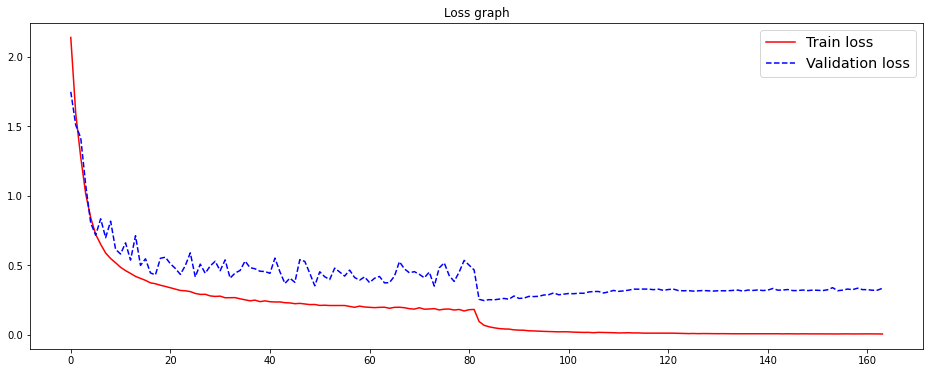

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.title('Loss graph')
plt.plot(history['train_loss'], 'r-')
plt.plot(history['valid_loss'], 'b--')
plt.legend(['Train loss', 'Validation loss'], fontsize='x-large')
plt.show()

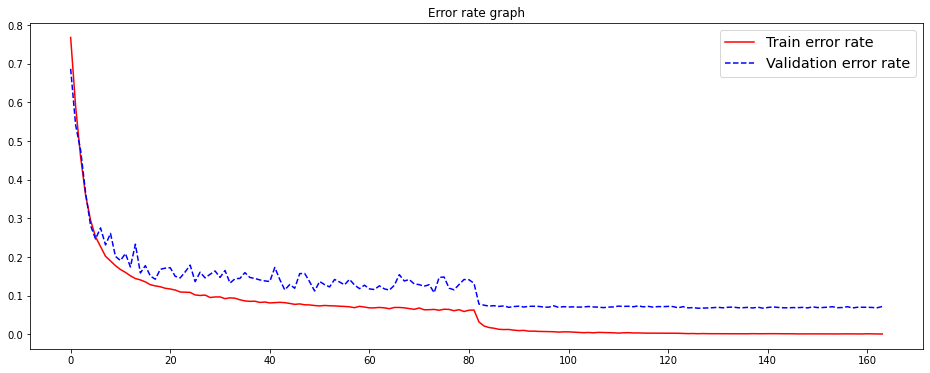

In [7]:
plt.figure(figsize=(16, 6))
plt.title('Error rate graph')
plt.plot(history['train_err_rate'] * 100, 'r-')
plt.plot(history['valid_err_rate'] * 100, 'b--')
plt.legend(['Train error rate', 'Validation error rate'], fontsize='x-large')
plt.show()

In [8]:
history['valid_err_rate'][-1] * 100

7.209256329113924